<a href="https://colab.research.google.com/github/kapoor1309/BH-25/blob/main/BH_lund.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

class T50(Dataset):
    def __init__(self, img_dir, annotation_file, transform=None):
        with open(annotation_file, 'r') as file:
            annotations = json.load(file)
        self.annotations = annotations["annotations"]
        self.img_dir = img_dir
        self.transform = transform
        self.frame_ids = list(self.annotations.keys())

    def __len__(self):
        return len(self.frame_ids)

    def __getitem__(self, index):
        frame_id = self.frame_ids[index]
        triplets = self.annotations[frame_id]

        basename = f"{str(frame_id).zfill(6)}.png"
        img_path = os.path.join(self.img_dir, basename)

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file not found: {img_path}")

        if self.transform:
            image = self.transform(image)

        count_labels = self.get_count_labels(triplets)

        return image, count_labels, frame_id

    def get_count_labels(self, labels):
        tool_counts = np.zeros(6)  # Assuming 6 classes
        for label in labels:
            tool = label[1:2]
            if tool[0] != -1.0:
                tool_counts[tool[0]] += 1
        return tool_counts

class CustomCholecT50:
    def __init__(self, dataset_dir, train_videos, test_videos, normalize=True):
        self.dataset_dir = dataset_dir
        self.train_videos = train_videos
        self.test_videos = test_videos
        self.normalize = normalize

        train_transform, test_transform = self.transform()
        self.train_transform = train_transform
        self.test_transform = test_transform

        self.build_test_dataset(self.test_transform)

    def transform(self):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        train_transform = transforms.Compose([
            transforms.Resize((256, 448)),
            transforms.TrivialAugmentWide(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            normalize
        ])

        test_transform = transforms.Compose([
            transforms.Resize((256, 448)),
            transforms.ToTensor(),
            normalize
        ])

        return train_transform, test_transform

    def build_train_dataset(self, video_indices, transform):
        iterable_dataset = []
        for video in video_indices:
            dataset = T50(
                img_dir=os.path.join(self.dataset_dir, f"videos/VID{str(video).zfill(2)}"),
                annotation_file=os.path.join(self.dataset_dir, f"labels/VID{str(video).zfill(2)}.json"),
                transform=transform
            )
            iterable_dataset.append(dataset)
        return ConcatDataset(iterable_dataset)

    def build_test_dataset(self, transform):
        iterable_dataset = []
        for video in self.test_videos:
            dataset = T50(
                img_dir=os.path.join(self.dataset_dir, f"videos/VID{str(video).zfill(2)}"),
                annotation_file=os.path.join(self.dataset_dir, f"labels/VID{str(video).zfill(2)}.json"),
                transform=transform
            )
            iterable_dataset.append(dataset)
        self.test_dataset = ConcatDataset(iterable_dataset)

    def get_train_val_datasets(self, train_videos, val_videos):
        train_dataset = self.build_train_dataset(train_videos, self.train_transform)
        val_dataset = self.build_train_dataset(val_videos, self.test_transform)
        return train_dataset, val_dataset

    def build(self):
        return self.test_dataset

def train_model_limited_steps(model, train_loader, val_loader, num_steps, learning_rate, device):
    """Train the model for a limited number of steps."""
    criterion = nn.MSELoss()  # Mean Squared Error for count prediction
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    running_loss = 0.0

    for i, (images, labels, _) in enumerate(tqdm(train_loader, desc=f"Training (Limited Steps: {num_steps})")):
        if i >= num_steps:  # Stop after the desired number of steps
            print(f"Stopped training after {num_steps} steps.")
            break

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        print(f"Step [{i+1}/{num_steps}], Loss: {loss.item():.4f}")

    val_loss = evaluate_model(model, val_loader, criterion, device)
    print(f"Training Loss: {running_loss/num_steps:.4f}, Validation Loss: {val_loss:.4f}")


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()
    return val_loss / len(dataloader)

if __name__ == "__main__":
    dataset_dir = "/content/CholecT50"
    train_videos = [6, 2, 8, 1, 4, 14, 5, 10, 12, 13]
    test_videos = [92, 96, 103, 110, 111]  # Define test_videos properly

    cholect = CustomCholecT50(dataset_dir, train_videos, test_videos, normalize=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Split train_videos into training and validation sets manually
    train_videos_subset = train_videos[:8]
    val_videos_subset = train_videos[8:]

    train_dataset, val_dataset = cholect.get_train_val_datasets(train_videos_subset, val_videos_subset)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 6)  # 6 output units for 6 instrument counts
    model = model.to(device)

    print("Training model...")
    # train_model(model, train_loader, val_loader, num_epochs=2, learning_rate=0.0001, device=device)
    train_model_limited_steps(model, train_loader, val_loader, num_steps=30, learning_rate=0.0001, device=device)

    # Save the trained model
    # torch.save(model.state_dict(), "trained_model.pth")


In [ ]:
import os
import json
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

# Dataset classes
class CustomCholecT50:
    def __init__(self, dataset_dir, train_videos, test_videos, normalize=True, split_ratio=0.8):
        self.dataset_dir = dataset_dir
        self.train_videos = train_videos
        self.test_videos = test_videos
        self.normalize = normalize
        self.split_ratio = split_ratio

        train_transform, test_transform = self.transform()
        self.train_transform = train_transform
        self.test_transform = test_transform

        self.build_train_valid_datasets(self.train_transform)
        self.build_test_dataset(self.test_transform)

    def transform(self):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        op_test = [transforms.Resize((224, 224)), transforms.ToTensor()]
        op_train = [transforms.Resize((224, 224)), transforms.ToTensor()]

        if self.normalize:
            op_test.append(normalize)
            op_train.append(normalize)

        test_transform = transforms.Compose(op_test)
        train_transform = transforms.Compose(op_train)

        return train_transform, test_transform

    def build_train_valid_datasets(self, transform):
        iterable_dataset = []
        for video in self.train_videos:
            dataset = T50(
                img_dir=os.path.join(self.dataset_dir, f"videos/VID{str(video).zfill(2)}"),
                annotation_file=os.path.join(self.dataset_dir, f"labels/VID{str(video).zfill(2)}.json"),
                transform=transform
            )
            iterable_dataset.append(dataset)
        full_dataset = torch.utils.data.ConcatDataset(iterable_dataset)

        train_size = int(self.split_ratio * len(full_dataset))
        valid_size = len(full_dataset) - train_size
        self.train_dataset, self.valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

    def build_test_dataset(self, transform):
        iterable_dataset = []
        for video in self.test_videos:
            dataset = T50(
                img_dir=os.path.join(self.dataset_dir, f"videos/VID{str(video).zfill(2)}"),
                annotation_file=os.path.join(self.dataset_dir, f"labels/VID{str(video).zfill(2)}.json"),
                transform=transform
            )
            iterable_dataset.append(dataset)
        self.test_dataset = torch.utils.data.ConcatDataset(iterable_dataset)

    def build(self):
        return self.train_dataset, self.valid_dataset, self.test_dataset


class T50(torch.utils.data.Dataset):
    def __init__(self, img_dir, annotation_file, transform=None):
        with open(annotation_file, 'r') as file:
            annotations = json.load(file)
        self.annotations = annotations["annotations"]
        self.img_dir = img_dir
        self.transform = transform
        self.frame_ids = list(self.annotations.keys())

    def __len__(self):
        return len(self.frame_ids)

    def __getitem__(self, index):
        frame_id = self.frame_ids[index]
        triplets = self.annotations[frame_id]

        basename = f"{str(frame_id).zfill(6)}.png"
        img_path = os.path.join(self.img_dir, basename)

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file not found: {img_path}")

        if self.transform:
            image = self.transform(image)

        triplet_label, tool_label, verb_label, target_label = self.get_binary_labels(triplets)
        return image, triplet_label, tool_label, verb_label, target_label

    def get_binary_labels(self, labels):
        tool_label = np.zeros([6])
        verb_label = np.zeros([10])
        target_label = np.zeros([15])
        triplet_label = np.zeros([100])

        for label in labels:
            triplet = label[0:1]
            if triplet[0] != -1.0:
                triplet_label[triplet[0]] = 1
            tool = label[1:7]
            if tool[0] != -1.0:
                tool_label[tool[0]] = 1
            verb = label[7:8]
            if verb[0] != -1.0:
                verb_label[verb[0]] = 1
            target = label[8:14]
            if target[0] != -1.0:
                target_label[target[0]] = 1

        return triplet_label, tool_label, verb_label, target_label


In [ ]:
import torch.nn as nn
from torchvision import models

# Model definition
class MultiTaskModel(nn.Module):
    def __init__(self, num_triplets, num_tools, num_verbs, num_targets):
        super(MultiTaskModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()
        backbone_output_dim = 2048

        self.triplet_head = nn.Linear(backbone_output_dim, num_triplets)
        self.tool_head = nn.Linear(backbone_output_dim, num_tools)
        self.verb_head = nn.Linear(backbone_output_dim, num_verbs)
        self.target_head = nn.Linear(backbone_output_dim, num_targets)

    def forward(self, x):
        features = self.backbone(x)
        triplet_preds = self.triplet_head(features)
        tool_preds = self.tool_head(features)
        verb_preds = self.verb_head(features)
        target_preds = self.target_head(features)
        return triplet_preds, tool_preds, verb_preds, target_preds


In [ ]:
# Initialize Dataset and Dataloader
dataset_dir = "/content/CholecT50"
train_videos = [6, 2, 8, 1, 4, 14, 5, 10, 12, 13]
test_videos = [92, 96, 103, 110, 111]

cholect = CustomCholecT50(dataset_dir, train_videos, test_videos)
train_dataset, valid_dataset, test_dataset = cholect.build()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel(num_triplets=100, num_tools=6, num_verbs=10, num_targets=15).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (images, triplet_labels, tool_labels, verb_labels, target_labels) in enumerate(train_loader):
        images = images.to(device)
        triplet_labels = triplet_labels.to(device)
        tool_labels = tool_labels.to(device)
        verb_labels = verb_labels.to(device)
        target_labels = target_labels.to(device)

        triplet_preds, tool_preds, verb_preds, target_preds = model(images)

        loss_triplet = criterion(triplet_preds, triplet_labels)
        loss_tool = criterion(tool_preds, tool_labels)
        loss_verb = criterion(verb_preds, verb_labels)
        loss_target = criterion(target_preds, target_labels)

        total_loss = loss_triplet + loss_tool + loss_verb + loss_target

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Step {batch_idx+1}/{len(train_loader)}, Loss: {total_loss.item():.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 86.3MB/s]


Epoch 1/3, Step 1/883, Loss: 2.6320
Epoch 1/3, Step 2/883, Loss: 2.5708
Epoch 1/3, Step 3/883, Loss: 2.4343
Epoch 1/3, Step 4/883, Loss: 2.2624
Epoch 1/3, Step 5/883, Loss: 2.1067
Epoch 1/3, Step 6/883, Loss: 1.9971
Epoch 1/3, Step 7/883, Loss: 1.9157
Epoch 1/3, Step 8/883, Loss: 1.7597
Epoch 1/3, Step 9/883, Loss: 1.6704
Epoch 1/3, Step 10/883, Loss: 1.5798
Epoch 1/3, Step 11/883, Loss: 1.5003
Epoch 1/3, Step 12/883, Loss: 1.4897
Epoch 1/3, Step 13/883, Loss: 1.4402
Epoch 1/3, Step 14/883, Loss: 1.3663
Epoch 1/3, Step 15/883, Loss: 1.2283
Epoch 1/3, Step 16/883, Loss: 1.2651
Epoch 1/3, Step 17/883, Loss: 1.1931
Epoch 1/3, Step 18/883, Loss: 1.1693
Epoch 1/3, Step 19/883, Loss: 1.0894
Epoch 1/3, Step 20/883, Loss: 1.0277
Epoch 1/3, Step 21/883, Loss: 0.9559
Epoch 1/3, Step 22/883, Loss: 0.8806
Epoch 1/3, Step 23/883, Loss: 0.9255
Epoch 1/3, Step 24/883, Loss: 0.8345
Epoch 1/3, Step 25/883, Loss: 0.8197
Epoch 1/3, Step 26/883, Loss: 0.9822
Epoch 1/3, Step 27/883, Loss: 0.9958
Epoch 1/3,

<ipython-input-38-11511d3f567a>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/trained_model_fold_.pth"))  # Load the trained m

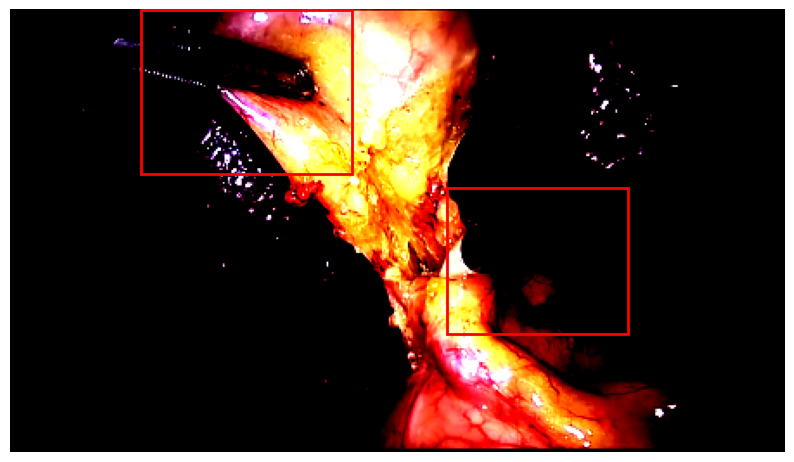

CAM image saved to: frame_000007_tool_0_cam.png
Bounding Boxes: [[252, 103, 357, 187], [75, 0, 197, 95]]


In [ ]:
import os
import torch
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Function to generate CAM and bounding boxes for a single image
def generate_cam_and_bounding_boxes_for_single_image(model, image_path, transform, cam_extractor, device):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Generate CAM for the image
    grayscale_cam = cam_extractor(input_tensor=image, targets=[ClassifierOutputTarget(0)])  # Assume tool_id = 0
    cam = grayscale_cam[0]

    # Normalize CAM
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize CAM to [0, 1]
    threshold = 0.5  # Example threshold
    binary_mask = (cam >= threshold).astype(np.uint8) * 255

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)  # Get bounding box
        bounding_boxes.append([x, y, x + w, y + h])  # Store as [x1, y1, x2, y2]

    # Show the CAM on the image
    original_image = np.array(image.squeeze(0).cpu().numpy().transpose(1, 2, 0))
    normalized_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
    cam_image = show_cam_on_image(normalized_image.astype(np.float32), cam, use_rgb=True)

    # Save the CAM image
    cam_image_path = f"frame_000007_tool_0_cam.png"
    Image.fromarray(cam_image).save(cam_image_path)

    # Display bounding boxes and visualize the image
    visualize_image_with_bounding_boxes(original_image, bounding_boxes)

    return cam_image_path, bounding_boxes

# Function to visualize the image with bounding boxes
def visualize_image_with_bounding_boxes(image, bounding_boxes):
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Draw bounding boxes
    for bbox in bounding_boxes:
        x1, y1, x2, y2 = bbox
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red", linewidth=2))

    # Show the image with bounding boxes
    plt.axis("off")
    plt.show()

# Main code
if __name__ == "__main__":
    # Set up directories and model
    image_path = "/content/CholecT50/videos/VID01/000094.png"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((256, 448)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load the saved model
    model = models.resnet50(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, 6)  # 6 output units
    model.load_state_dict(torch.load("/content/trained_model_fold_.pth"))  # Load the trained model
    model = model.to(device)
    model.eval()

    # Initialize GradCAM
    cam_extractor = GradCAM(model=model, target_layers=[model.layer4[-1]])

    # Generate CAM and bounding boxes for the single image
    cam_image_path, bounding_boxes = generate_cam_and_bounding_boxes_for_single_image(
        model, image_path, transform, cam_extractor, device
    )
    print(f"CAM image saved to: {cam_image_path}")
    print(f"Bounding Boxes: {bounding_boxes}")


Original Image Dimensions: 854x480


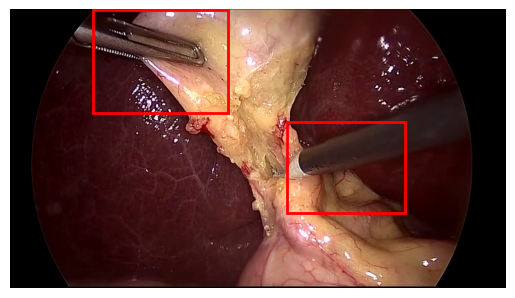

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-39-9dac830666cf>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

Processing Bounding Box 1 with coordinates: [476.5625, 193.125, 680.53125, 350.625]...
Triplet Predictions for Box 1: tensor([[0.0007, 0.0009, 0.0007, 0.0103, 0.0134, 0.0013, 0.0008, 0.0158, 0.0032,
         0.0032, 0.0057, 0.0055, 0.0084, 0.0031, 0.0009, 0.0025, 0.0010, 0.2110,
         0.0122, 0.0801, 0.0130, 0.0056, 0.0006, 0.0005, 0.0013, 0.0010, 0.0029,
         0.0008, 0.0018, 0.0008, 0.0007, 0.0010, 0.0011, 0.0012, 0.0023, 0.0011,
         0.0013, 0.0012, 0.0009, 0.0015, 0.0013, 0.0008, 0.0014, 0.0012, 0.0027,
         0.0040, 0.0037, 0.0009, 0.0012, 0.0011, 0.0008, 0.0030, 0.0030, 0.0031,
         0.0012, 0.0012, 0.0014, 0.0107, 0.0982, 0.0048, 0.0228, 0.0043, 0.0025,
         0.0070, 0.0044, 0.0009, 0.0029, 0.0013, 0.0025, 0.0081, 0.0047, 0.0044,
         0.0033, 0.0008, 0.0009, 0.0027, 0.0011, 0.0041, 0.0043, 0.0554, 0.0013,
         0.0067, 0.0205, 0.0011, 0.0010, 0.0011, 0.0012, 0.0007, 0.0059, 0.0018,
         0.0049, 0.0010, 0.0034, 0.0013, 0.0354, 0.0027, 0.0066, 0.0050,

In [ ]:
import os
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


# Function to crop the image based on bounding box coordinates
def crop_image(image, bbox):
    x1, y1, x2, y2 = bbox
    # Convert bounding box coordinates to integers before slicing
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    return image[y1:y2, x1:x2]  # Crop the image using bounding box coordinates


# Function to preprocess the cropped image
def preprocess_image(image, transform, device):
    pil_image = Image.fromarray(image)
    return transform(pil_image).unsqueeze(0).to(device)  # Apply the same transform used for training


# Function to load the saved model
def load_model(model_path, device):
    model = MultiTaskModel(num_triplets=100, num_tools=6, num_verbs=10, num_targets=15)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()  # Set model to evaluation mode
    return model


# Function to predict using the cropped image
def predict_cropped_image(model, cropped_image, transform, device):
    # Get the transformed image ready for model input
    transformed_image = preprocess_image(cropped_image, transform, device)

    # Get predictions from the model
    with torch.no_grad():
        triplet_preds, tool_preds, verb_preds, target_preds = model(transformed_image)

    # Convert logits to probabilities (for visualization or decision making)
    triplet_preds = torch.sigmoid(triplet_preds)
    tool_preds = torch.sigmoid(tool_preds)
    verb_preds = torch.sigmoid(verb_preds)
    target_preds = torch.sigmoid(target_preds)

    return triplet_preds, tool_preds, verb_preds, target_preds


# Main code for cropping and making predictions
if __name__ == "__main__":
    image_path = "/content/CholecT50/videos/VID01/000094.png"
    model_path = "/content/multi_task_model.pth"

    # Set up the device and transformations
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load the image and get the bounding boxes
    image = Image.open(image_path).convert("RGB")
    original_image = np.array(image)
    original_height, original_width, _ = original_image.shape
    print(f"Original Image Dimensions: {original_width}x{original_height}")

    # Rescale bounding boxes based on the original and resized dimensions
    width_scale = 854/448 # 0.524
    height_scale = 480/256  # 0.533

    # Example bounding boxes
    [252, 103, 357, 187], [75, 0, 197, 95]
    bounding_boxes = [[250 * width_scale, 103 * height_scale, 357 * width_scale, 187 * height_scale],
                      [75*width_scale,0*height_scale,197*width_scale,95*height_scale]]

    # Visualize all bounding boxes on the original image
    plt.imshow(original_image)
    for bbox in bounding_boxes:
        # Convert bbox coordinates to int for visualization
        x1, y1, x2, y2 = map(int, bbox)
        plt.gca().add_patch(plt.Rectangle((x1, y1),
                                          x2 - x1,
                                          y2 - y1,
                                          fill=False, color="red", linewidth=2))
    plt.axis('off')
    plt.show()

    # Load the trained model
    model = load_model(model_path, device)

    # Process each bounding box and make predictions
    for i, bbox in enumerate(bounding_boxes):
        print(f"Processing Bounding Box {i+1} with coordinates: {bbox}...")

        # Crop the image based on the bounding box
        cropped_image = crop_image(original_image, bbox)

        # Make predictions on the cropped image
        triplet_preds, tool_preds, verb_preds, target_preds = predict_cropped_image(model, cropped_image, transform, device)

        # Display the predictions for the current bounding box
        print(f"Triplet Predictions for Box {i+1}: {triplet_preds}")
        print(f"Tool Predictions for Box {i+1}: {tool_preds}")
        print(f"Verb Predictions for Box {i+1}: {verb_preds}")
        print(f"Target Predictions for Box {i+1}: {target_preds}")